In [28]:
import matplotlib
from src.repository.surebet_repository import SurebetRepository
from src.repository.game_repository import GameRepository
from src.genetic.arbitrage import CrossOverEnum, Population
from src.util import ExportadorDeGraficos, PickleSerializer
from datetime import datetime
game_repository = GameRepository()
repository = SurebetRepository()

<h3> Parâmetros para execução do experimento </h3>

In [29]:
n_generations = 150
n_individuals = 50
mutation_rate = 0.05
crossover_rate = 0.98
crossover=CrossOverEnum.UNIFORM_CROSSOVER

In [30]:
# start_date = '2023-09-02 14:00:00'
# end_date = '2023-09-02 14:05:00'
# arbitrages = repository.find_all_unique_between(start_date, end_date)
# population = Population(n_generations=n_generations, n_individuals=n_individuals, mutation_rate=mutation_rate, crossover_rate=crossover_rate, 
#                         budget=1000, crossover_strategy=crossover, arbitrages=arbitrages)

In [31]:
# import pygmo as pg
# reference_point = [1.0, 1.0]
# x_values = []
# y_values = []
# for g, front in population.pareto_history_front_normalized:
#     x_values.append(g)
#     y_values.append(pg.hypervolume(front).compute(reference_point))
# 
# 
# title = f'Population: {population.n_individuals} Mutation: {population.mutation_rate}'
# plt = matplotlib.pyplot
# plt.xlabel('Generations')
# plt.ylabel('Hypervolume Score')
# plt.title(title)
# plt.scatter(x_values, y_values, s=15)
# plt.show()
# plt.close()


<h3>Métodos auxiliares para plot, consulta ao banco e munipulação dos dados</h3>

In [32]:
def get_teams(ids):
    return game_repository.get_teams(ids)

In [33]:
import matplotlib.pyplot as plt

def paretos_frontier_evolution_plot(population: Population, export: ExportadorDeGraficos):
    plt.figure()
    # plt.xlim(0, 1.05)
    # plt.ylim(0, 1.05)
    plt.title('Evolução da Fronteira de Pareto')
    plt.xlabel('Profit')
    plt.ylabel('Dispersation')
    colors = ['#7634BB', '#2BF063', '#9DC3E6']
    path = export.data_hora_atual + '/' + 'pareto_evolution.png'
    evolution_points = len(population.evolution_front)
    aux = population.evolution_front[0], population.evolution_front[evolution_points//2], population.evolution_front[-1]

    aux = [(h, sorted(f, key=lambda x :x[1])) for h, f in aux]
    count = 0
    for hypervolume, front, in aux:
        x = [i[0] for i in front]
        y = [i[1] for i in front]
        plt.plot(x, y, marker='o', label=f'Hv = {hypervolume:,.4f}')
        plt.scatter(x, y, color=colors[count])
        count += 1
    plt.legend()
    plt.plot()
    plt.show()
    plt.savefig(path)
    plt.close()


In [34]:
def paretos_frontier_plot(front, selected_individuals, path):
    plt = matplotlib.pyplot
    plt.figure()
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.title(f'Pareto Front')
    plt.xlabel('Profit')
    plt.ylabel('Dispersation')
    plt.scatter([i.fitness_normalized[0] for i in front], [i.fitness_normalized[1] for i in front])
    plt.scatter([i.fitness_normalized[0] for i in selected_individuals], [i.fitness_normalized[1] for i in selected_individuals], color='#2BF063')
    plt.plot([i.fitness_normalized[0] for i in front], [i.fitness_normalized[1] for i in front], color='red', linewidth=1, linestyle='-')
    plt.savefig(path)
    plt.close()


def pick_up_individuals(front):   
    front_fitness = list({tuple(i.fitness) for i in front})  # Remove os itens repetidos
    OPTIMIZE_PROFIT = -1
    OPTIMIZE_MIDDLE = ((len(front_fitness) // 2) - 1)
    OPTIMIZE_DISPERSATION = 0
    
    front_sorted = sorted(front, key=lambda x: x.fitness[0])
    front_fitness = sorted(front_fitness, key=lambda x: x[0])
    
    aux_individuals_selected = front_fitness[OPTIMIZE_PROFIT], front_fitness[OPTIMIZE_MIDDLE], front_fitness[OPTIMIZE_DISPERSATION]  # Seleciona os 3 indivíduos (Aqui só tem os fitness)
    selected = []
    
    # Método para descobrir qual a é o indivíduo(dentro da fronteira de pareto que possui vários objetos) que possui o fitness escolhido anteriormente
    for i in aux_individuals_selected:
        for individual in front_sorted:
            if list(i) == individual.fitness:
                selected.append(individual)
                break

    return front_sorted, selected

def normalize(front, high_fitness_evaluated):
    max_profit = high_fitness_evaluated[0]
    max_dispersation = high_fitness_evaluated[1]
    for i in front:
        profit_normalized = i.fitness[0] / max_profit
        dispersation_normalized = i.fitness[1] / max_dispersation
        i.fitness_normalized = [profit_normalized, dispersation_normalized]
    

In [35]:
def export_frontier(export: ExportadorDeGraficos, population: Population):
    evolution_frontier_x = list()
    evolution_frontier_y = list()
    generation_plot = [0, population.n_generations - 1, population.best_frontier-1]
    for generation, front in population.pareto_history_front_normalized:
        x = [i[0] for i in front]
        y = [i[1] for i in front]
        if generation in generation_plot:
            export.plot(x, y, generation+1)
            evolution_frontier_x.append(x)
            evolution_frontier_y.append(y)
    paretos_frontier_evolution_plot(population, export)
    

def export_solution(population: Population, front_sorted, individuals_selected, export: ExportadorDeGraficos):
    export.hypervolume_plot(population)
    PickleSerializer.save(population, f'{export.data_hora_atual}/pickle.pkl')
    path = export.data_hora_atual + '/' + export.get_file_name(population.best_frontier, 'png')
    export_frontier(export, population)
    paretos_frontier_plot(front_sorted, individuals_selected, path)
    
    
def plot_frontier(population: Population, export: ExportadorDeGraficos):
    if population.best_frontier is None:
        export.calculate_hypervolume(population)

    print(population.best_frontier)

    frontier = population.pareto_history_front[population.best_frontier][1]
    
    front_sorted, individuals_selected = pick_up_individuals(frontier)
    
    normalize(front_sorted, population.high_fitness_evaluated)
    normalize(individuals_selected, population.high_fitness_evaluated)

    export_solution(population, front_sorted, individuals_selected, export)

    return individuals_selected

In [36]:
from src.genetic.arbitrage import Individual

def decode_individual(individual: Individual, population: Population, individual_label, report_header, path, teams_dict: dict, verbose=True):
    profit = individual.fitness[0]
    number_of_surebets_chosen = sum([i[0] for i in individual.chromosome])
    surebets_selected = []
        
    for gene, arbitrage in zip(individual.chromosome, individual.arbitrages):
        if gene[0] == 1:
            surebets_selected.append((f'Game: {teams_dict.get(arbitrage.game_id)}', f'Bookmaker 1: {arbitrage.bookmaker_key_OVER}', f'Bookmaker 2: {arbitrage.bookmaker_key_UNDER}', f'Amount bet R$ {round(gene[1] * population.budget, 2)}', f'Profit R$ {((gene[1]*population.budget)*(arbitrage.profit/100)):,.2f}', f'{arbitrage.profit:,.2f}%'))
    
    if verbose:
        print(individual_label)
        print(f'Number of surebets chosen: {number_of_surebets_chosen}')
        print('Surebets Selected:')
        for i in surebets_selected:
            print(i)
    
        print(f'Total Profit: R$ {profit:,.2f}')
        print('-------------------------------------------------------------------------------------------------------------------------------------------------------')
    
    with open(path, 'a') as file:
        if report_header is not None:
            file.write(report_header)

        file.write(f'{individual_label}\n')
        file.write(f'Number of surebets chosen: {number_of_surebets_chosen}\n')
        file.write('Surebets Selected:\n')
        for i in surebets_selected:
            file.write(str(i)+'\n')
        file.write(f'Total Profit: R$ {profit:,.2f}\n')
        file.write('-------------------------------------------------------------------------------------------------------------------------------------------------------\n')
        
    

In [37]:
def run_scenario(start_date = '2023-09-02 14:00:00', end_date = '2023-09-02 14:05:00', verbose=True, count=0):
    export = ExportadorDeGraficos()
    
    arbitrages = repository.find_all_unique_between(start_date, end_date)
    population = Population(n_generations=n_generations, n_individuals=n_individuals, mutation_rate=mutation_rate, crossover_rate=crossover_rate, 
                            budget=1000, crossover_strategy=crossover, arbitrages=arbitrages)
    
    teams_dict = get_teams([i.game_id for i in arbitrages])
    individuals_picked_up = plot_frontier(population, export)
#     
#     labels = ['Profit Optimization', 'Equilibrium Optimization', 'Dispersation Optimization']
#     folder = export.data_hora_atual
#     start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S').strftime('%H:%M')
#     end = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').strftime('%H:%M')
#     date_event = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S').strftime('%d/%m/%Y')
#     path = f"{folder}/report_{start}_{end}.txt"
#     
#     report_header = f"""************************************************************* EXPERIMENTAL RESULT REPORT *************************************************************
# 
# [Date]: {date_event}
# [Surebet Interval]: {start} to {end}
# [Best frontier]: {population.best_frontier + 1}º generation
# [Budget]: R$ {population.budget:,.2f}
# 
# """
#     for label, individual in zip(labels, individuals_picked_up):
#         decode_individual(individual, population, label, report_header, path, teams_dict, verbose)
#         report_header = None


<h3> Cenários mês de setembro </h3>
<img src="images/surebets_setembro.png" width="75%">
<br> <br>
<img src="images/surebets_02_setembro.png" width="75%">

<h3> Cenário 02/09/2023 </h3>

32


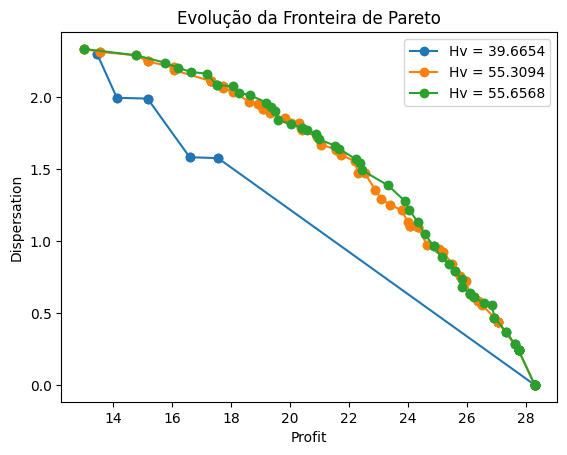

In [38]:
run_scenario(start_date='2023-09-02 14:00:00', end_date='2023-09-02 14:05:00', verbose=False)

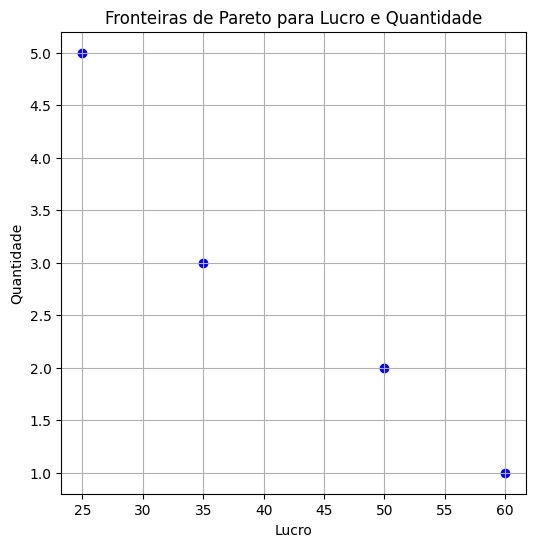

In [39]:
import matplotlib.pyplot as plt

# Dados fictícios - lucro e quantidade
lucro = [60, 50, 35, 25]
quantidade = [1, 2, 3, 5]

# Plot das fronteiras
plt.figure(figsize=(6, 6))
plt.scatter(lucro, quantidade, color='blue')
plt.xlabel('Lucro')
plt.ylabel('Quantidade')
plt.title('Fronteiras de Pareto para Lucro e Quantidade')
plt.grid(True)
plt.show()


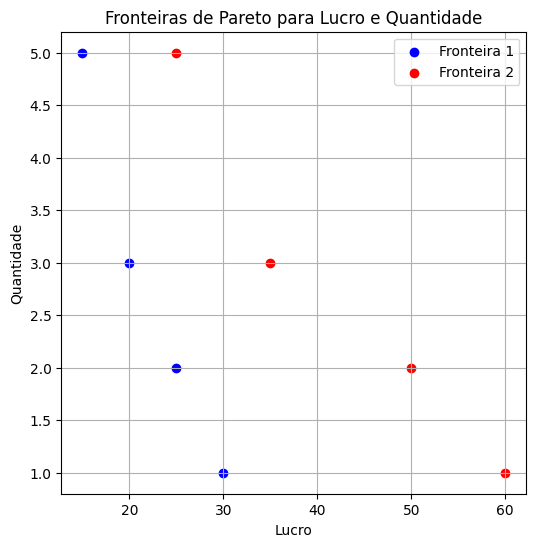

In [40]:
import matplotlib.pyplot as plt

lucro = [30, 25, 20, 15]
quantidade = [1, 2, 3, 5]

lucro_2 = [60, 50, 35, 25]
quantidade_2 = [1, 2, 3, 5]

fronteira_1 = list(zip(lucro, quantidade))
fronteira_2 = list(zip(lucro_2, quantidade_2))

# Dados fictícios - lucro e quantidade (outra fronteira)


# Plot das fronteiras
plt.figure(figsize=(6, 6))
plt.scatter(lucro, quantidade, color='blue', label='Fronteira 1')
plt.scatter(lucro_2, quantidade_2, color='red', label='Fronteira 2')
plt.xlabel('Lucro')
plt.ylabel('Quantidade')
plt.title('Fronteiras de Pareto para Lucro e Quantidade')
plt.legend()
plt.grid(True)
plt.show()



In [41]:
import numpy as np
import pygmo as pg
from sklearn.preprocessing import MaxAbsScaler

lucro = [30, 25, 20, 15]
quantidade = [1, 2, 3, 5]

lucro_2 = [60, 50, 35, 25]
quantidade_2 = [1, 2, 3, 5]

fronteira_1 = list(zip(lucro, quantidade))
fronteira_2 = list(zip(lucro_2, quantidade_2))

# print(fronteira_1)
# print(fronteira_2)

# Inicialize o MaxAbsScaler
scaler = MaxAbsScaler()

# Ajuste o scaler com seus dados
scaler.fit(fronteira_1)
scaler.fit(fronteira_2)

# Normalize os valores de fitness usando o scaler
normalized_fitness_values = scaler.transform(fronteira_1)
normalized_fitness_values2 = scaler.transform(fronteira_2)
normalized_fitness_values3 = [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]

normalized_fitness_values = - np.array(normalized_fitness_values)
normalized_fitness_values2 = - np.array(normalized_fitness_values2)
normalized_fitness_values3 = - np.array(normalized_fitness_values3)

print(normalized_fitness_values)
print(normalized_fitness_values2)
print(normalized_fitness_values3)

reference_point = [1, 1]  # Ponto de referência para o cálculo do hypervolume

hypervolume_1 = pg.hypervolume(normalized_fitness_values).compute(reference_point)
hypervolume_2 = pg.hypervolume(normalized_fitness_values2).compute(reference_point)
hypervolume_3 = pg.hypervolume(normalized_fitness_values3).compute(reference_point)

print("Hypervolume da Fronteira 1:", hypervolume_1)
print("Hypervolume da Fronteira 2:", hypervolume_2)
print("Hypervolume da Fronteira 3:", hypervolume_3)

[[-0.5        -0.2       ]
 [-0.41666667 -0.4       ]
 [-0.33333333 -0.6       ]
 [-0.25       -1.        ]]
[[-1.         -0.2       ]
 [-0.83333333 -0.4       ]
 [-0.58333333 -0.6       ]
 [-0.41666667 -1.        ]]
[[-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]]
Hypervolume da Fronteira 1: 2.8499999999999996
Hypervolume da Fronteira 2: 3.65
Hypervolume da Fronteira 3: 1.0


In [42]:
a = ((38.071389138653345, [[11.66, 2.0013107967134687], [28.3, 0.0], [19.31, 1.5188455359952018], [28.3, 0.0], [13.76, 1.9948439850956858], [16.82, 1.584381457724494], [17.43, 1.5835835289081928], [14.13, 1.9854752972273344], [19.45, 1.5095699919979075]]), (54.16046092450308, [[28.3, 0.0], [12.65, 2.321878211554419], [28.3, 0.0], [27.06, 0.43646981706410287], [27.06, 0.43646981706410287], [15.739999999999998, 2.21747048442868], [14.81, 2.2815579629343494], [24.569999999999997, 0.978854149486896], [25.61, 0.8419597010603894], [13.41, 2.3164962473497366], [19.16, 1.8170263227506485], [15.21, 2.232511804816265], [16.860000000000003, 1.9556054787356354], [25.97, 0.6577047787442195], [23.03, 1.319945934282163], [26.66, 0.5293608652873644], [22.35, 1.3896402143504476], [17.630000000000003, 1.8974419114340755], [25.81, 0.7554828938846007], [20.14, 1.7301967654791677], [23.11, 1.1812908992306925], [23.959999999999997, 1.0826086854086878], [23.17, 1.1803283888251836], [26.66, 0.5293608652873644], [20.259999999999998, 1.7000752272963802], [21.579999999999995, 1.5318901760346346], [21.17, 1.6008671441775528], [21.32, 1.5771268546389854], [23.75, 1.1428845675349106], [26.38, 0.584238811642856], [25.06, 0.9477595267272505], [19.839999999999996, 1.7330057218152404], [21.509999999999998, 1.5511795212346569], [17.56, 1.918338611952362], [17.56, 1.918338611952362], [18.05, 1.8744495377989094], [17.21, 1.9391416922610447], [26.24, 0.6098403047164004], [25.830000000000002, 0.6800770457282799], [22.279999999999998, 1.4418121370262966], [26.24, 0.6098403047164004], [18.32, 1.8595491373832154], [18.74, 1.8490370019931333], [23.860000000000003, 1.1012124086606425], [19.55, 1.7420247595149514], [20.479999999999997, 1.671064038730018], [26.51, 0.557438185027989], [22.069999999999997, 1.478897902987479], [28.3, 0.0], [25.830000000000002, 0.6800770457282799], [21.23, 1.5873224771823107], [25.12, 0.8981862747335008], [25.75, 0.759359049513646], [19.16, 1.8170263227506485], [20.96, 1.6273425430602495], [22.89, 1.3264117566166815], [15.740000000000002, 2.203552823734883], [26.38, 0.584238811642856], [24.43, 1.043643442625333], [16.78, 2.162422781035626], [26.51, 0.557438185027989], [24.15, 1.0540157730728], [25.330000000000002, 0.8974442414335516]]), (54.70881066238354, [[28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [13.32, 2.3322864441199966], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [27.470000000000002, 0.24229218908241482], [27.470000000000002, 0.24229218908241482], [27.470000000000002, 0.24229218908241482], [15.799999999999999, 2.234253068140682], [18.86, 1.8186885704510973], [18.18, 1.8642430683528575], [16.11, 2.1575880563538754], [20.830000000000005, 1.6243138728700308], [25.89, 0.747584679824574], [25.89, 0.747584679824574], [19.220000000000002, 1.783178203715123], [19.770000000000003, 1.736414685238271], [13.600000000000001, 2.3074373087779434], [23.96, 1.2203392961334694], [21.5, 1.5355180332029907], [20.48, 1.6664048070381712], [24.37, 1.1523253078232503], [20.2, 1.7146210628630094], [16.720000000000002, 2.141413684436059], [22.07, 1.4810768800263723], [17.599999999999998, 2.0249228317044876], [17.849999999999998, 1.9517114853914383], [22.419999999999998, 1.4198363984493816], [27.34, 0.36592365090022316], [27.34, 0.36592365090022316], [21.38, 1.5688494212735313], [23.54, 1.2788961762894906], [26.380000000000003, 0.6927411007953421], [22.910000000000004, 1.3917966871478546], [17.05, 2.12544039671622], [24.779999999999998, 1.0310272735633705], [24.85, 0.9461447090189017], [17.26, 2.02707698614419], [28.3, 0.0], [28.3, 0.0], [17.599999999999998, 2.0249228317044876], [23.74, 1.2656634455139302], [25.21, 0.9193428728556348], [26.66, 0.5293608652873644], [28.3, 0.0], [27.470000000000002, 0.24229218908241482], [17.25, 2.0758124120941575], [27.06, 0.43646981706410287], [28.3, 0.0], [27.470000000000002, 0.24229218908241482], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [13.32, 2.3322864441199966], [28.3, 0.0], [25.68, 0.8337187735247162], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0], [26.1, 0.7050756912421843], [28.3, 0.0], [28.3, 0.0], [28.3, 0.0]]))

In [43]:
for h, f in a:
    print(f)
    print(sorted(f, key=lambda x:x[1]))

# print([sorted(a, key=lambda x:x[1]) for i in a])

[[11.66, 2.0013107967134687], [28.3, 0.0], [19.31, 1.5188455359952018], [28.3, 0.0], [13.76, 1.9948439850956858], [16.82, 1.584381457724494], [17.43, 1.5835835289081928], [14.13, 1.9854752972273344], [19.45, 1.5095699919979075]]
[[28.3, 0.0], [28.3, 0.0], [19.45, 1.5095699919979075], [19.31, 1.5188455359952018], [17.43, 1.5835835289081928], [16.82, 1.584381457724494], [14.13, 1.9854752972273344], [13.76, 1.9948439850956858], [11.66, 2.0013107967134687]]
[[28.3, 0.0], [12.65, 2.321878211554419], [28.3, 0.0], [27.06, 0.43646981706410287], [27.06, 0.43646981706410287], [15.739999999999998, 2.21747048442868], [14.81, 2.2815579629343494], [24.569999999999997, 0.978854149486896], [25.61, 0.8419597010603894], [13.41, 2.3164962473497366], [19.16, 1.8170263227506485], [15.21, 2.232511804816265], [16.860000000000003, 1.9556054787356354], [25.97, 0.6577047787442195], [23.03, 1.319945934282163], [26.66, 0.5293608652873644], [22.35, 1.3896402143504476], [17.630000000000003, 1.8974419114340755], [25


### Cenário 24/09/2023
